# We are going planet hunting!
Using the Kepler Light Intensity of Stars Data we will predict whether a star has a confirmed exo-planet orbiting it.  
The data presented here are cleaned and are derived from observations made by the NASA Kepler space telescope. The Mission is ongoing
LABEL -> 2 is an exoplanet star and 1 is a non-exoplanet-star.
FLUX1-FLUX3197 -> the light intensity recorded for each star, at a different point in time.
data is from https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data

## What are we looking for?
When a planet orbiting a star passes between the star and the Kepler Space Telescope the light intensity dims in a ‘v’ or ‘u’ shape.  Our model will pick up this characteristic.  
## The challenge:
Star brightness dim with time, sunspots and other naturally occurring phenomena.  
The space telescope is moving and background noise is in the data despite being cleaned by NASA.
## Approach:
* We will import the data and explore it.
* We will convert the data from the time domain to frequency using a Fast Fourier Transform (FFT).
* We will also remove light flux noise from the data of both the time and frequency data using a Gaussian blurring filter.
* We will perform logistic regression on the data to show we are able to predict whether a star has an orbiting exo-planet.  
* We will boost the model’s performance using a 1D Convolutional Neural Network (currently in progress)

First we import some basic python libraries

In [1]:
import pandas as pd
import numpy as np
import scipy

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train=pd.read_csv('exoTrain.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


In [5]:
train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [6]:
train.tail()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55
5086,1,323.28,306.36,293.16,287.67,249.89,218.30,188.86,178.93,118.93,...,71.19,0.97,55.20,-1.63,-5.50,-25.33,-41.31,-16.72,-14.09,27.82


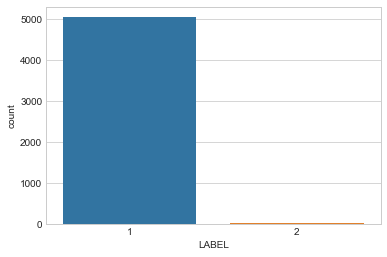

In [7]:
#Countplot to illustrate the imbalance in the dataset
sns.set_style('whitegrid')
sns.countplot(x='LABEL',data=train)

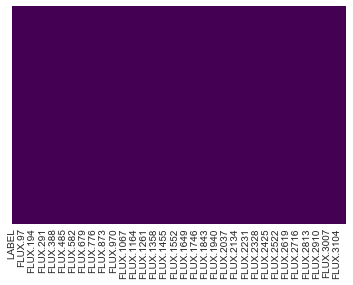

In [8]:
#heatmap ensures there are no missing data
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
# generate an array of time data that corresponds to the flux data points
time=np.linspace(0,1920,3197) #80 days*24 hours =1920 hours
time

array([  0.00000000e+00,   6.00750939e-01,   1.20150188e+00, ...,
         1.91879850e+03,   1.91939925e+03,   1.92000000e+03])

In [10]:
# generate an array of frequency data that corresponds to the flux FFT data points
frequency=np.linspace(0,1.4787,3197)  # Sampling frequency is 1 frame per ~36 minutes, or about 0.00046 Hz
frequency.max()

1.4786999999999999

In [11]:
# Converts to frequency domain
def spectrum_converter(X):
    Spectrum = scipy.fft(X, n=X.size)
    return np.abs(Spectrum)

In [12]:
#removes label column
train_nolabel =train.drop('LABEL',axis=1)

In [13]:
#perform FFT
train_fft=train_nolabel.apply(spectrum_converter, axis =1)

In [14]:
train_nolabel.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [15]:
train_fft.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,31822.48,3542.697260,55671.612807,52952.701956,200751.502826,29353.124433,25093.521120,16709.544467,28812.723753,25559.772897,...,2992.545812,25559.772897,28812.723753,16709.544467,25093.521120,29353.124433,200751.502826,52952.701956,55671.612807,3542.697260
1,23747.10,18904.034831,23034.013754,23943.701671,13819.563577,20765.092016,17303.647198,7401.036438,8735.502062,8872.865012,...,7383.345790,8872.865012,8735.502062,7401.036438,17303.647198,20765.092016,13819.563577,23943.701671,23034.013754,18904.034831
2,26180.51,143610.487591,41912.294689,365999.616787,104066.520704,189543.713858,123398.774919,83153.412884,22577.194163,99916.175640,...,48754.521520,99916.175640,22577.194163,83153.412884,123398.774919,189543.713858,104066.520704,365999.616787,41912.294689,143610.487591
3,14855.14,12371.439885,33309.457851,69042.125217,64290.918441,172076.407434,49458.284691,45511.563319,35061.742616,21291.359595,...,17060.829321,21291.359595,35061.742616,45511.563319,49458.284691,172076.407434,64290.918441,69042.125217,33309.457851,12371.439885
4,45527.39,310414.084694,140433.251401,400661.916141,406211.307176,283810.829694,319055.791578,79144.154130,99624.063739,189609.298602,...,13455.026552,189609.298602,99624.063739,79144.154130,319055.791578,283810.829694,406211.307176,400661.916141,140433.251401,310414.084694


In [16]:
#import gaussian blur
from  scipy import ndimage

In [17]:
# Set standard deviation on Gaussian blurring filter
sigma=3

In [18]:
#perform Gaussian blur filter on time domain light intensity
smoothed_arr=ndimage.filters.gaussian_filter(train_nolabel.copy(), sigma=sigma)

In [19]:
#Converts array to pandas dataframe
smoothed_df=pd.DataFrame(smoothed_arr,list(train_nolabel.index.values),list(train_nolabel.columns.values))

In [20]:
smoothed_df.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,50.775143,47.463754,41.461861,33.820001,25.719790,18.178216,11.873947,7.144600,4.116582,2.876720,...,-51.496623,-49.199916,-45.313586,-40.827349,-36.908391,-34.464443,-33.813801,-34.597375,-35.960216,-36.950779
1,40.118798,37.078404,31.572751,24.573584,17.172159,10.306372,4.602842,0.376508,-2.249032,-3.182957,...,-49.914055,-47.469750,-43.559649,-39.141376,-35.328892,-32.976311,-32.369024,-33.145871,-34.475454,-35.438330
2,21.438822,18.834239,14.122278,8.141474,1.832242,-3.997024,-8.802244,-12.301871,-14.373914,-14.919321,...,-41.687935,-39.134111,-35.275313,-30.973698,-27.240233,-24.856049,-24.090928,-24.628924,-25.723282,-26.541453
3,-0.620126,-2.790114,-6.721201,-11.723490,-17.020402,-21.938200,-26.012102,-28.986243,-30.733216,-31.141775,...,-18.409229,-16.105697,-12.553164,-8.394741,-4.487401,-1.573602,-0.010344,0.336445,-0.005178,-0.392403
4,-21.001466,-22.891548,-26.340002,-30.782883,-35.574765,-40.138959,-44.055560,-47.070223,-49.038558,-49.834493,...,28.020589,29.364210,32.150538,36.152143,40.727915,45.089040,48.597273,50.964929,52.275601,52.813533


In [21]:
#Convert Gaussian blur filter time domain light intensity to frequency domain
smoothed_fft_df=smoothed_df.apply(spectrum_converter, axis =1)

In [22]:
smoothed_fft_df.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2454.060822,33735.273582,20388.031570,70676.892773,96689.007205,11224.606218,59093.529830,12222.996345,11799.056660,36985.204624,...,11606.517839,36985.204624,11799.056660,12222.996345,59093.529830,11224.606218,96689.007205,70676.892773,20388.031570,33735.273582
1,1411.428414,36632.454138,19267.884311,69945.369276,95919.246507,12480.551084,60283.534213,9982.135685,12787.350213,38272.111307,...,11749.463276,38272.111307,12787.350213,9982.135685,60283.534213,12480.551084,95919.246507,69945.369276,19267.884311,36632.454138
2,13.993611,41552.787545,20220.918775,70227.931299,94555.030585,16349.271453,60065.386651,5074.086195,14714.223407,40012.758793,...,11713.724958,40012.758793,14714.223407,5074.086195,60065.386651,16349.271453,94555.030585,70227.931299,20220.918775,41552.787545
3,439.856220,46670.402798,33485.928471,71500.788442,93233.622260,23368.715848,54454.259425,3224.611316,16881.975307,41109.225863,...,11043.711128,41109.225863,16881.975307,3224.611316,54454.259425,23368.715848,93233.622260,71500.788442,33485.928471,46670.402798
4,1631.486960,50135.597595,65599.887215,70736.700175,93587.611889,34798.092732,40451.998542,15456.243330,18566.142076,41035.081344,...,9537.756419,41035.081344,18566.142076,15456.243330,40451.998542,34798.092732,93587.611889,70736.700175,65599.887215,50135.597595


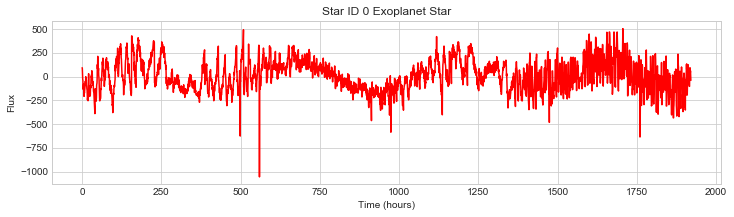

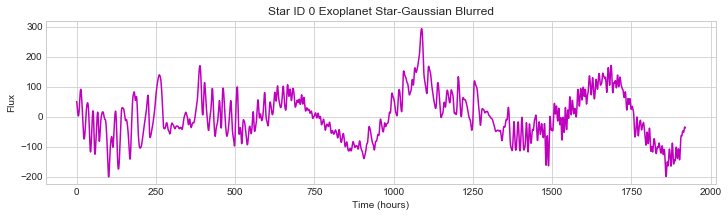

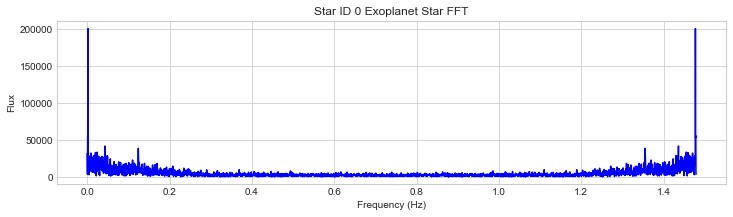

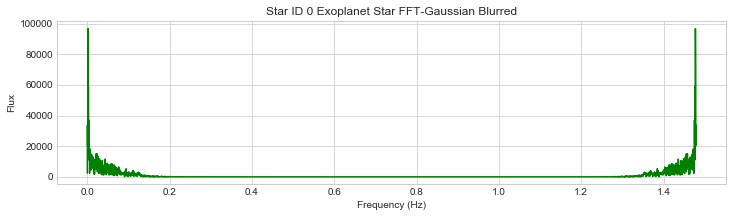

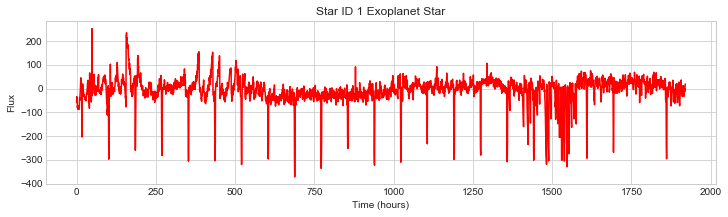

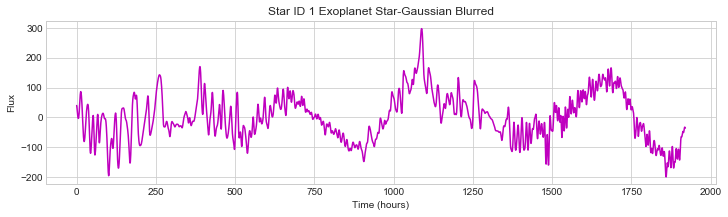

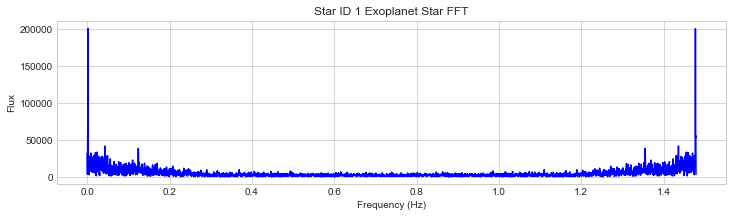

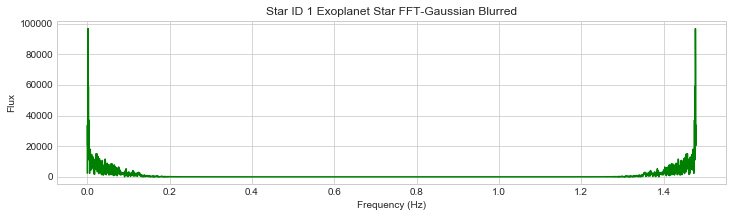

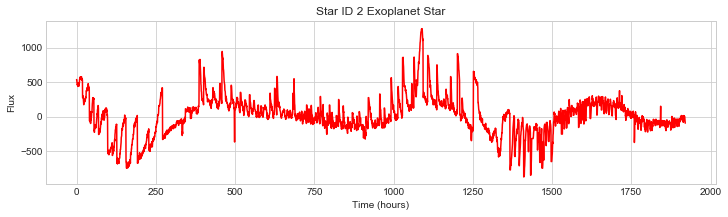

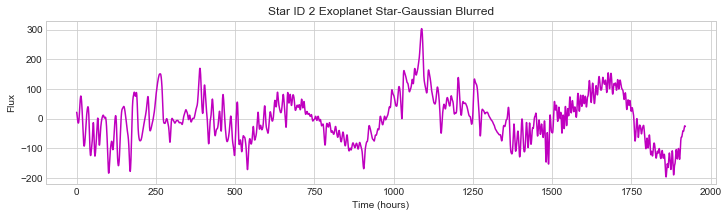

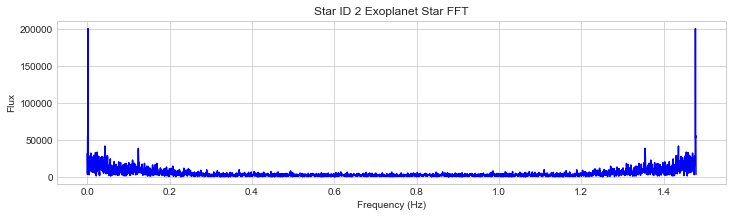

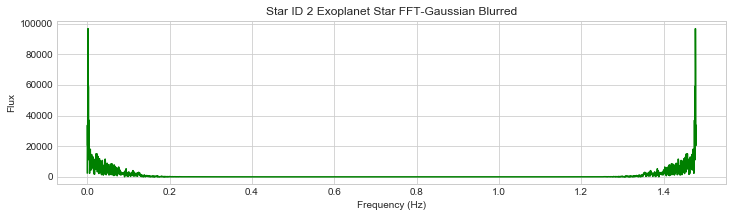

In [23]:
#plot Stars with exo-planets light intensity
for i in range(3):
    # Original Light Flux Plot
    plt.figure(figsize=(12,3))
    plt.plot(time,train_nolabel.iloc[i],'r-')
    plt.xlabel('Time (hours)')
    plt.ylabel('Flux')
    plt.title('Star ID {} Exoplanet Star'.format(i))
    #Gaussian Blurred Plot
    plt.figure(figsize=(12,3))
    plt.plot(time,smoothed_df.iloc[i],'m-')
    plt.xlabel('Time (hours)')
    plt.ylabel('Flux')
    plt.title('Star ID {} Exoplanet Star-Gaussian Blurred'.format(i))
    
    #Fast Fourier Transfom plots
    plt.figure(figsize=(12,3))
    plt.plot(frequency,train_fft.iloc[0],'b-')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Flux')
    plt.title('Star ID {} Exoplanet Star FFT'.format(i))
    #Gaussian Blurred Plot FFT
    plt.figure(figsize=(12,3))
    plt.plot(frequency,smoothed_fft_df.iloc[0],'g-')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Flux')
    plt.title('Star ID {} Exoplanet Star FFT-Gaussian Blurred'.format(i))

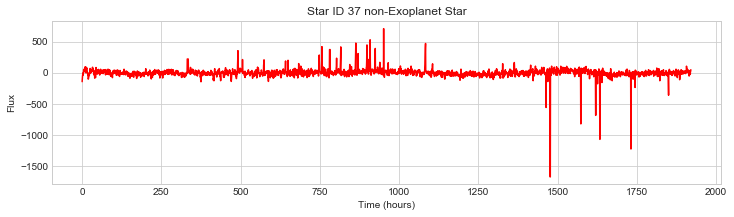

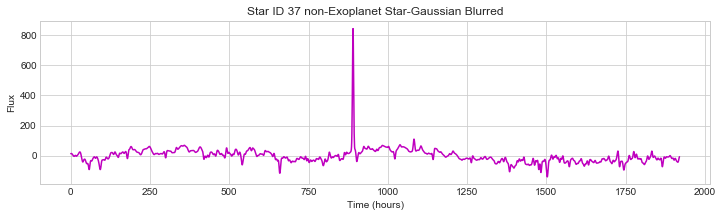

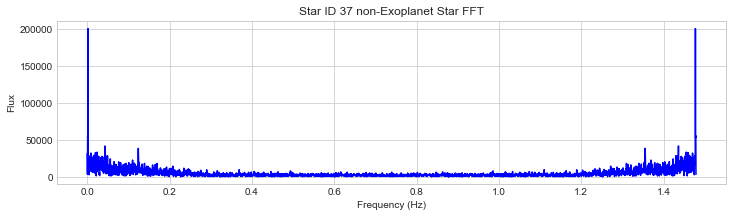

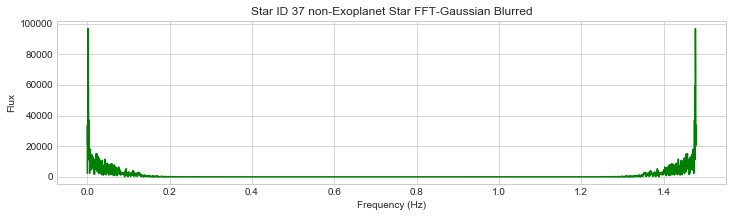

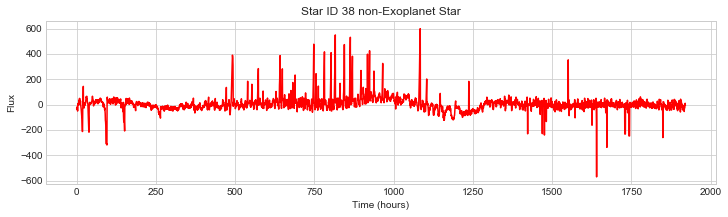

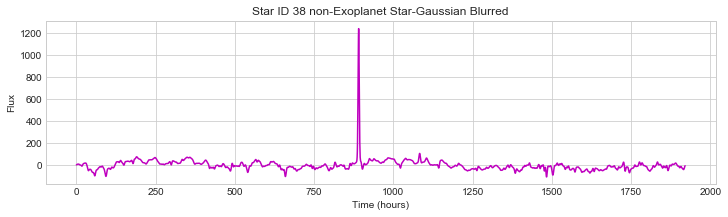

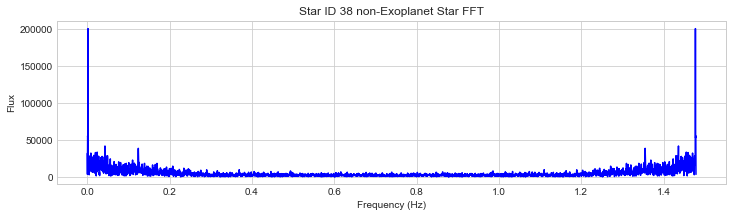

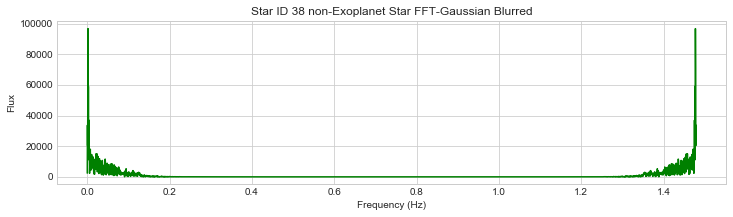

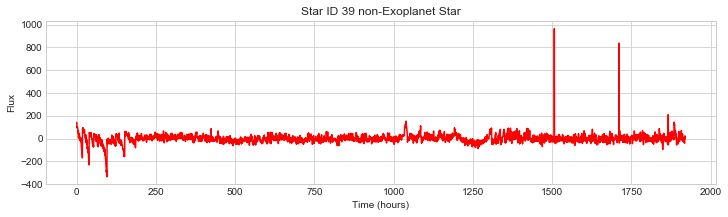

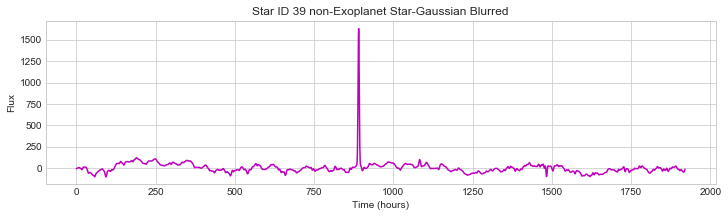

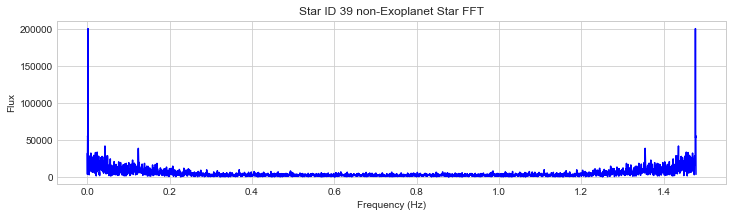

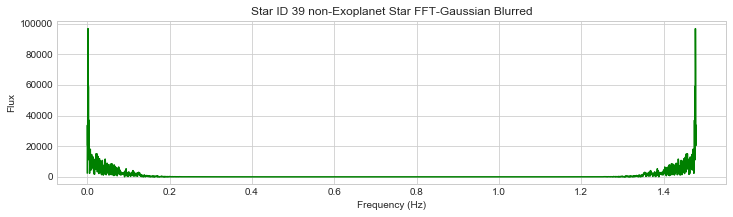

In [24]:
#plot Stars with NO exo-planets light intensity
for i in range(37,40,1):
    # Original Light Flux Plot
    plt.figure(figsize=(12,3))
    plt.plot(time,train_nolabel.iloc[i],'r-')
    plt.xlabel('Time (hours)')
    plt.ylabel('Flux')
    plt.title('Star ID {} non-Exoplanet Star'.format(i))
    #Gaussian Blurred Plot
    plt.figure(figsize=(12,3))
    plt.plot(time,smoothed_df.iloc[i],'m-')
    plt.xlabel('Time (hours)')
    plt.ylabel('Flux')
    plt.title('Star ID {} non-Exoplanet Star-Gaussian Blurred'.format(i))
    
    #Fast Fourier Transfom plots
    plt.figure(figsize=(12,3))
    plt.plot(frequency,train_fft.iloc[0],'b-')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Flux')
    plt.title('Star ID {} non-Exoplanet Star FFT'.format(i))
    #Gaussian Blurred Plot FFT
    plt.figure(figsize=(12,3))
    plt.plot(frequency,smoothed_fft_df.iloc[0],'g-')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Flux')
    plt.title('Star ID {} non-Exoplanet Star FFT-Gaussian Blurred'.format(i))

## DataFrames:
* train_nolabel
* smoothed_df
* train_fft
* smoothed_fft_df

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X=smoothed_fft_df
y=train['LABEL']

# Building a Logistic Regression model
Let’s start by splitting our data into a training set and test set (there is another test.csv file that we
will use for scoring after the model is build).

#### Train Test Split:
we will preserve teh ratio of imbalance in the test and training sets

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, 
                                                    stratify=y,random_state=101)

#### Training and Predicting

In [ ]:
from sklearn.linear_model import LogisticRegression

In [30]:
logmodel = LogisticRegression()

In [31]:
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
predictions = logmodel.predict(X_test)

## Evaluation:

In [33]:
from sklearn.metrics import classification_report,confusion_matrix

In [34]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          1       1.00      1.00      1.00      1011
          2       0.75      0.86      0.80         7

avg / total       1.00      1.00      1.00      1018



In [35]:
print(confusion_matrix(y_test,predictions))

[[1009    2]
 [   1    6]]


### Preliminary Conclusion:
Using a Gaussian Blurring filter is a good way to reduce noise in our light intensity data.  The logistic regression shows that we can predict if a star has an exo-planet with an acceptable level of accuracy. 

#### Up next is boosting the models performance using 1D convolutional Neural Networks… to be continued
 